In [1]:
# Copyright 2017 Junghoon Lee
#   jhoon.chris@gmail.com

In [2]:
import pandas_datareader as pdr
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame, Panel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from sp_ml import SpMl

In [8]:
class SpKnnReg(SpMl):
    'stock prediction by KNN regression'

    def __init__(self):
        pass
        
    def preprocess_fetures(self):
        #print self.ivv.head()
        self.nm_ivv = self.ivv.copy(deep=True)
        self.nm_ivv['Adj Close'] = self.nm_ivv['Adj Close']/self.nm_ivv['Adj Close'][0]
        self.nm_ivv['Volume'] = self.nm_ivv['Volume']/self.nm_ivv['Volume'].mean()
        self.nm_ivv['Open'] = (self.nm_ivv['Close']-self.nm_ivv['Open'])/self.nm_ivv['Open']
        self.nm_ivv['High'] = (self.nm_ivv['High']-self.nm_ivv['Low'])/self.nm_ivv['Low']
        self.nm_ivv = self.nm_ivv.rename(columns = {'Open':'Change'})
        self.nm_ivv = self.nm_ivv.rename(columns = {'High':'Maxofday'})
        #print self.nm_ivv.head()

        #print self.gld.head()
        self.nm_gld = self.gld.copy(deep=True)
        self.nm_gld['Adj Close'] = self.nm_gld['Adj Close']/self.nm_gld['Adj Close'][0]
        self.nm_gld['Volume'] = self.nm_gld['Volume']/self.nm_gld['Volume'].mean()
        #print self.nm_gld.head()

        self.prices = self.nm_ivv['Adj Close']
        self.features = self.nm_ivv.drop(['Close', 'Low'], axis = 1)

        # Rolling Mean 20 days
        self.rm20_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=20)
        self.rm20_ivv_ = pd.DataFrame(self.rm20_ivv)
        self.rm20_ivv_ = self.rm20_ivv_.rename(columns = {'Adj Close':'RM20'})
        #print self.rm20_ivv_.tail()

        # Rolling Mean 40 days
        self.rm40_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=40)
        self.rm40_ivv_ = pd.DataFrame(self.rm40_ivv)
        self.rm40_ivv_ = self.rm40_ivv_.rename(columns = {'Adj Close':'RM40'})

        #print gld.head()
        self.gold = self.nm_gld.drop(['Open', 'High', 'Close', 'Low', 'Volume'], axis = 1)
        self.gold = self.gold.rename(columns = {'Adj Close':'GLD'})
        #print gold.head()
        #print "gold.dtypes", gold.dtypes

        self.features = self.nm_ivv.drop(['Adj Close', 'Low', 'Close'], axis = 1)
        self.features = self.features.join(self.gold, how='inner')
        self.features = self.features.join(self.rm20_ivv_, how='inner')
        self.features = self.features.join(self.rm40_ivv_, how='inner')

        print self.features.head()
        return

    
    def display_fetures(self):
        self.ivv[['Close','Adj Close', 'Open', 'High', 'Low']].plot(title='IVV price')
        plt.show()

        self.nm_ivv['Volume'].plot(title='Nomalized IVV Volume')
        plt.show()

        self.gld[['Close','Adj Close', 'Open', 'High', 'Low']].plot(title='GLD price')
        plt.show()

        return

    
    def do_regression(self):
        X_train = self.features[65:-50]
        y_train = self.prices[70:-45]
        X_test = self.features[-50:-5]
        y_test = self.prices[-45:]

        # Show the results of the split
        print "Training set has {} samples.".format(X_train.shape[0])
        print "Testing set has {} samples.".format(X_test.shape[0])

        #print X_train.head()
        #print X_train[:,1]
        #print y_train.head()

        for count, n_neighbors in enumerate([2, 5, 7, 10, 15]):
            neigh = KNeighborsRegressor(n_neighbors, weights='distance')
            neigh.fit(X_train, y_train)
            y_pred = neigh.predict(X_test)
            print y_pred
            LR_result = pd.DataFrame(y_pred)
            LR_result.plot(title="n_neighbors %d" % n_neighbors)
            # The mean squared error
            print("n_neighbors : %d" % n_neighbors)
            print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
            # Explained variance score: 1 is perfect prediction
            print('Variance score: %.2f' % r2_score(y_test, y_pred))
    
        plt.show()
        
        return
        
        
    def predict_nextweek(self):
        # Predict future 1-week
        X_train = self.features[65:-5]
        y_train = self.prices[70:]
        X_future = self.features[-5:]

        neigh = KNeighborsRegressor(n_neighbors=2)
        neigh.fit(X_train, y_train)

        # Make predictions using the testing set
        y_future = neigh.predict(X_future)

        print y_future

        start_predict_day = now+datetime.timedelta(1)
        end_predict_day = now+datetime.timedelta(5)
        start_predict_day = start_predict_day.strftime("%Y-%m-%d")
        end_predict_day = end_predict_day.strftime("%Y-%m-%d")

        days = pd.date_range(start_predict_day, end_predict_day, freq='D')

        df = pd.DataFrame({'Date': days, 'Prediction': y_future})
        df = df.set_index('Date')
        df['Prediction'] = df['Prediction'] * self.ivv['Adj Close'][0]
        print df 

        real_prices = self.prices[-10:] * self.ivv['Adj Close'][0]
        ax = real_prices.plot()
        df['Prediction'].plot(title='Linear Regression stock price forecasting', ax = ax)
        plt.show()
        return
    

2017-12-14
loading :  IVV from :  2016-01-01  to :  2017-12-14
loading :  GLD from :  2016-01-01  to :  2017-12-14
              Change  Maxofday    Volume       GLD  RM20  RM40
Date                                                          
2016-01-04  0.002631  0.012125  2.013542  1.000000   NaN   NaN
2016-01-05  0.000544  0.009152  1.424148  1.002819   NaN   NaN
2016-01-06  0.002057  0.012338  1.487585  1.017300   NaN   NaN
2016-01-07 -0.006673  0.019684  2.041959  1.031684   NaN   NaN
2016-01-08 -0.016876  0.022283  2.409782  1.027116   NaN   NaN


/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=40,center=False).mean()


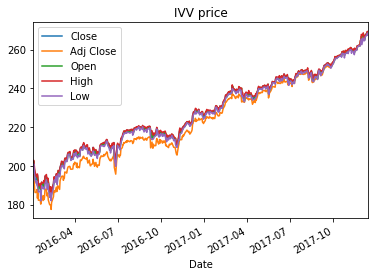

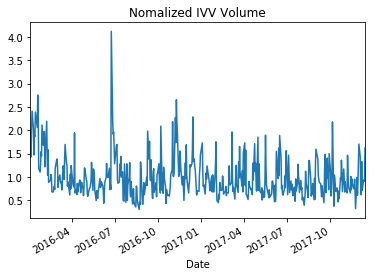

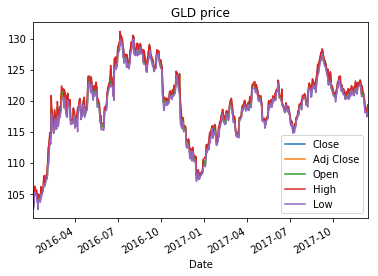

Training set has 378 samples.
Testing set has 45 samples.
[ 1.30019205  1.14687757  1.2727854   1.30821786  1.29739917  1.28993017
  1.29207241  1.30710551  1.29500102  1.27632369  1.28343623  1.25611422
  1.30586994  1.28136775  1.25443982  1.28135575  1.30574357  1.27852383
  1.25053865  1.27378557  1.25052114  1.3152199   1.28387855  1.30238008
  1.30865702  1.30419413  1.31534846  1.28370243  1.30603525  1.31524699
  1.29605727  1.26409954  1.31531757  1.30486408  1.29590911  1.27420277
  1.30596934  1.30654234  1.25068827  1.25443099  1.26432342  1.30695796
  1.30493612  1.30635     1.25443412]
n_neighbors : 2
Mean squared error: 0.00
Variance score: -10.44
[ 1.29536285  1.12583545  1.26512602  1.29775008  1.28677836  1.29212201
  1.28252264  1.29824869  1.28642864  1.26862163  1.28332223  1.27148097
  1.28721017  1.27816341  1.27094069  1.27990467  1.28278511  1.26743807
  1.26250244  1.28236281  1.2601296   1.29187896  1.27889044  1.28717128
  1.29997955  1.29671012  1.29605283 

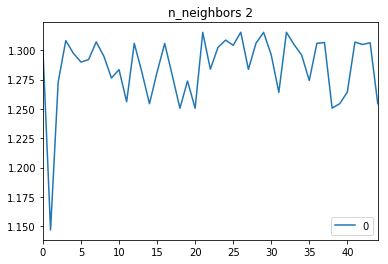

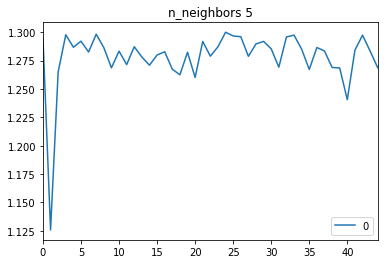

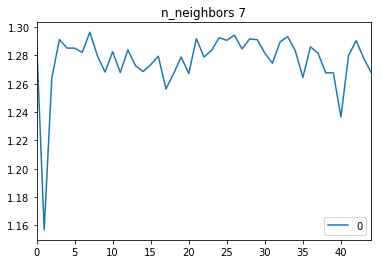

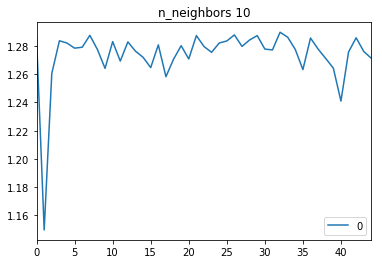

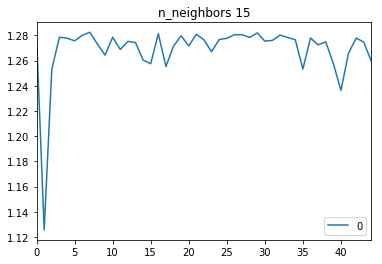

[ 1.33642835  1.3559871   1.34588722  1.34588722  1.32507513]
            Prediction
Date                  
2017-12-15  260.675004
2017-12-16  264.490005
2017-12-17  262.519989
2017-12-18  262.519989
2017-12-19  258.460518


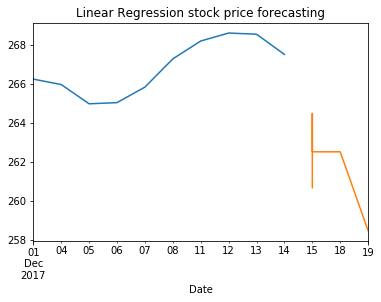

In [9]:
now = datetime.datetime.now()
end_date = now.strftime("%Y-%m-%d")
print end_date

kr_task = SpKnnReg()
kr_task.ivv = kr_task.get_input_feature('IVV', '2016-01-01', end_date)
kr_task.gld = kr_task.get_input_feature('GLD', '2016-01-01', end_date)

kr_task.preprocess_fetures()

kr_task.display_fetures()

kr_task.do_regression()

kr_task.predict_nextweek()